In [1]:
import PIL
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl

import dataset
import neural_network
import config as cfg

## Parameters

In [2]:
CLASSES = dataset.metadata.get_classes(cfg.paths.LABELS_CSV["train"])  
CLASSES, CLASSES.size

(array(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='<U5'), 7)

In [3]:
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH = dataset.metadata.get_image_dimensions(cfg.paths.IMG_DIR["train"])
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH

(3, 450, 600)

## Loading Checkpoint

In [4]:
SEED = 1
pl.seed_everything(SEED, workers=True)

Global seed set to 1


1

In [5]:
data_module = dataset.SkinCancerDataModule(
    cfg.paths.LABELS_CSV,
    cfg.paths.IMG_DIR,
    cfg.hparams.BATCH_SIZE,
    cfg.hparams.DATALOADER_NUM_WORKERS,
    transform=None
)

In [6]:
model = neural_network.ConvNetwork(CLASSES.size, cfg.hparams.DROPOUT_RATE)
print(model)

ConvNetwork(
  (first_conv): Sequential(
    (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_conv): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (third_conv): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Flatten(

/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
version = 0
CHECKPOINT_DIR = cfg.paths.LOG_DIR / f"lightning_logs/version_{version}" / "checkpoints"

CHECKPOINT_PATHS = list(CHECKPOINT_DIR.glob("*.ckpt")) 
CHECKPOINT_PATHS

[PosixPath('/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=1-step=106.ckpt'),
 PosixPath('/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=3-step=212.ckpt'),
 PosixPath('/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=0-step=53.ckpt')]

In [8]:
model_module: neural_network.NetworkModule = neural_network.NetworkModule.load_from_checkpoint(
    CHECKPOINT_PATHS[1],
    model=model,
    channels=IMG_CHANNELS,
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    num_classes=CLASSES.size,
    learning_rate=cfg.hparams.LEARNING_RATE
)

## Image

In [9]:
data_module.setup()
data_module.batch_size = 1 # overwrite with one to get only one image

dataloader = data_module.test_dataloader()
iter_dataloader = iter(dataloader)

In [10]:
from torchvision.transforms.functional import to_pil_image

imgs, labels = next(iter_dataloader)

label = labels[0]
img_tensor = imgs[0]

img = to_pil_image(imgs[0].type(torch.uint8))

CLASSES[label]

'NV'

(-0.5, 599.5, 449.5, -0.5)

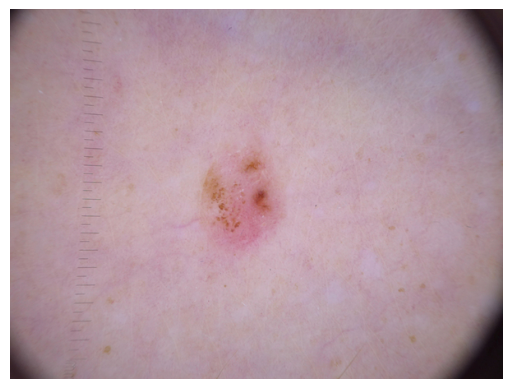

In [11]:
plt.imshow(img)
plt.axis("off")

## GradCAM

In [12]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [13]:
target_layers = [model_module.model.third_conv[-1]]

cam = GradCAM(
    model=model_module.model, 
    target_layers=target_layers, 
    use_cuda=True
)

In [14]:
targets = [ClassifierOutputTarget(label)]

# pass aug_smooth=True and eigen_smooth=True to apply smoothing.
grayscale_cam = cam(input_tensor=imgs, targets=targets)

In [15]:
norm_rgb_numpy = (img_tensor / 255).numpy()  # it needs to be a float between zero and one
norm_rgb_numpy = np.moveaxis(norm_rgb_numpy, 0, -1)  # it needs to be of shape (height, width, channels)

# grayscale_cam has only one image in the batch
grayscale_cam_first = grayscale_cam[0, :]

visualization = show_cam_on_image(norm_rgb_numpy, grayscale_cam_first, use_rgb=True)

(-0.5, 599.5, 449.5, -0.5)

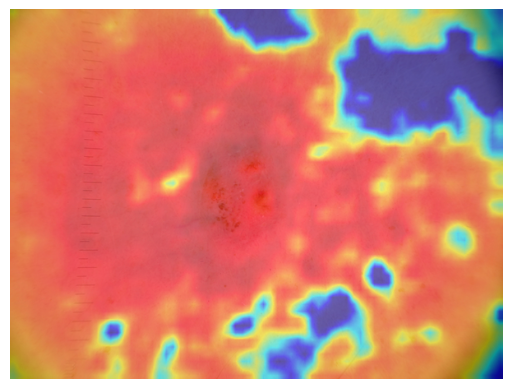

In [16]:
plt.imshow(visualization)
plt.axis("off")